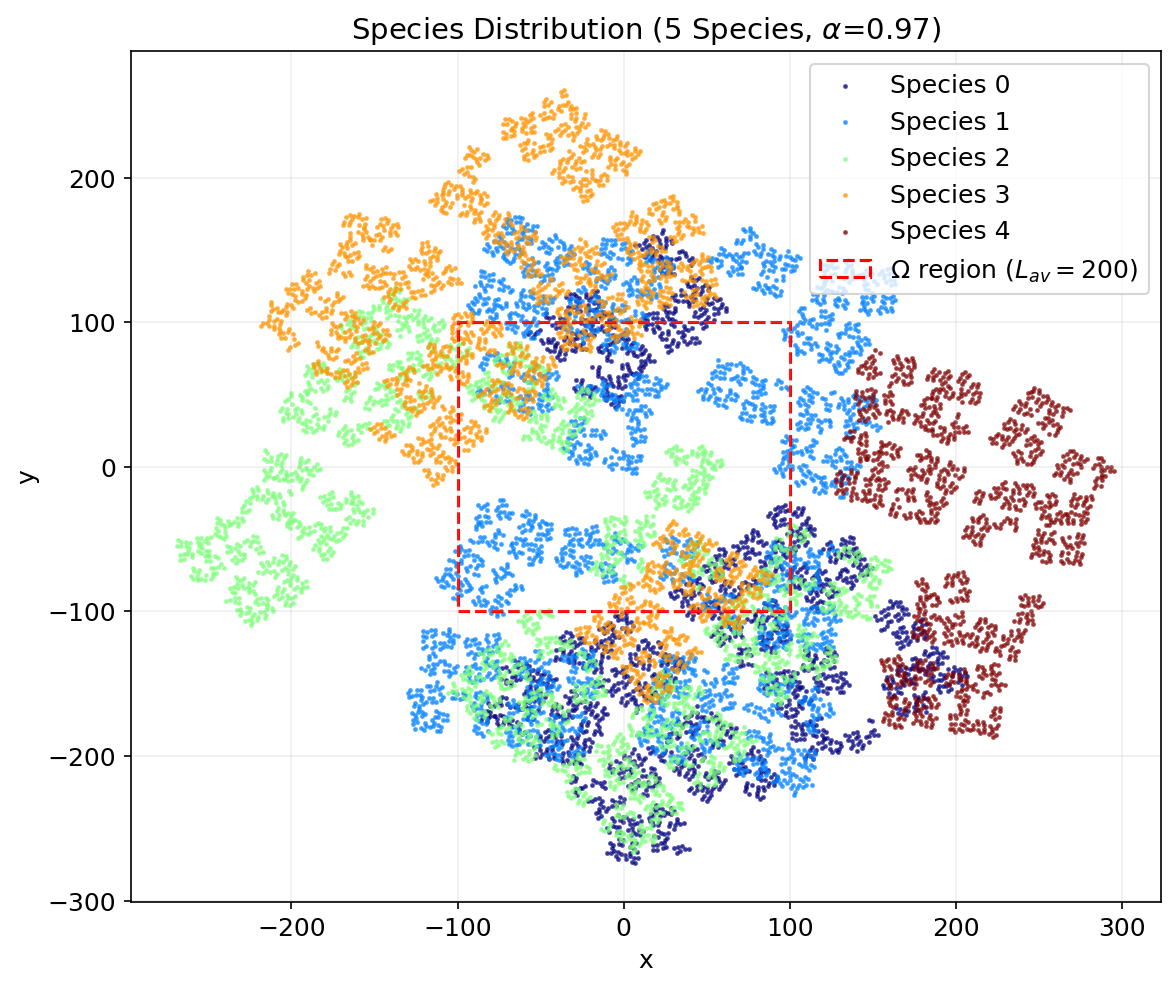

Fitted SAR: S = 3.72 * A^0.66


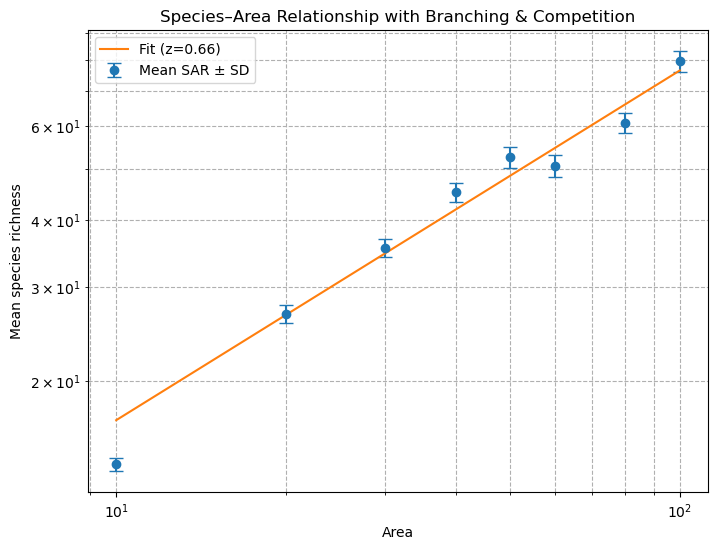

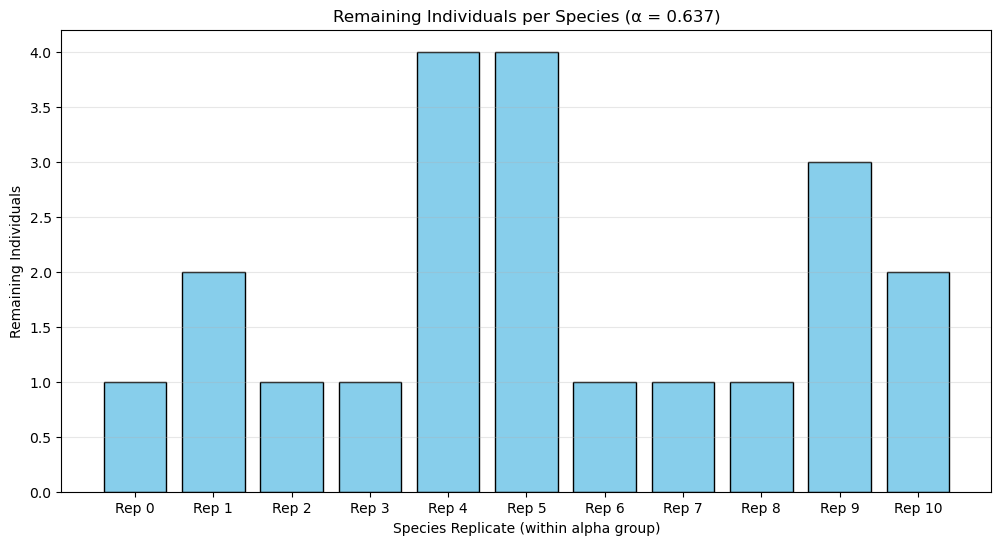

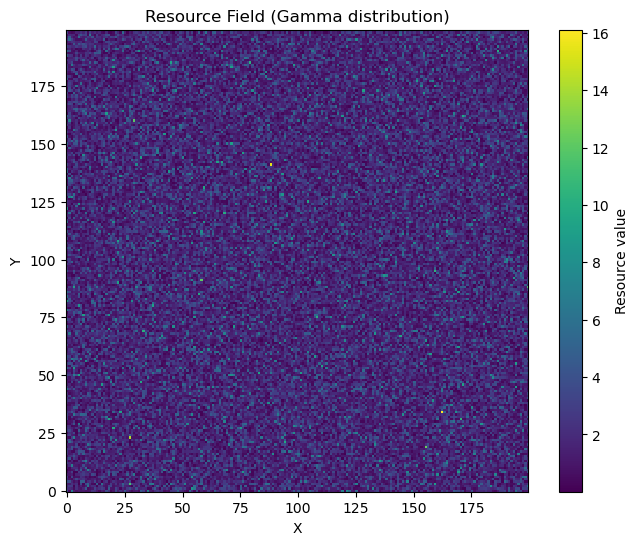

In [43]:
from enum import Enum
import json
import numpy as np
from matplotlib import patches, pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.neighbors import KDTree
from collections import Counter
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from plots import rcCustom, rcCustom_wide
class Branch(Enum):
    """
    How to branch for the population.
    """
    LEFT = 1
    RIGHT = 2
    BOTH = 4

class Individual:
    """
    X Y coordinates of an individual.
    """
    def __init__(self, x: float, y: float, theta: float, species_id: int = None, comp: float = 1.0):
        """
        Initialise a position for an individual.
        
        :param x: X coordinate of the individual
        :type x: float
        :param y: Y coordinate of the individual
        :type y: float
        """
        self.x = x
        self.y = y
        self.theta = theta
        self.species_id = species_id
        self.comp = comp

class Field:
    """
    Container for different individuals with competition.
    """
    def __init__(
        self,
        species_alpha: list[float],
        m: int,
        l: float,
        delta0: float,
        delta_diff: float,
        d: float,
        L_av: int,
        comp_values: list[float] = None  # competition coefficients
    ):
        """
        Initialise an area with branching species.

        :param species_alpha: Alpha parameter for each species
        :param m: Maximum number of branching iterations
        :param l: Starting branch length
        :param delta0: Initial delta angle
        :param delta_diff: Delta change factor
        :param d: Maximum initial point diameter
        :param L_av: Averaging area side length
        :param comp_values: Competition coefficient per species
        """
        assert m > 0 and l > 0 and d > 0
        self.species_alpha = species_alpha
        self.m = m
        self.l = l
        self.delta0 = delta0
        self.delta_diff = delta_diff
        self.d = d
        self.L_av = L_av
        self.omega_range = L_av / 2

        if comp_values is None:
            comp_values = [1.0] * len(species_alpha) # Initially no competition

        self.points = dict()
        previous_alpha = None
        count = 0
        species_id = 0  # global species counter

        for alpha in self.species_alpha:
            if alpha == previous_alpha:
                count += 1
            else:
                previous_alpha = alpha
                count = 0

            key = f"{alpha}-{count}"
            species_inds = self.generate_species(alpha)

            # assign species_id and competition coefficient
            for ind in species_inds:
                ind.species_id = species_id
                ind.comp = comp_values[species_id]

            self.points[key] = species_inds
            species_id += 1

    def generate_species(self, alpha: float) -> list:
        """Generate a species with a given alpha parameter."""
        branch_options = [Branch.LEFT, Branch.RIGHT, Branch.BOTH]
        p = [1 - alpha, 1 - alpha, 2*alpha - 1]

        # initial point
        theta0 = np.random.uniform(0, 2*np.pi)
        r0 = self.get_initial_point()
        x = np.array([r0.x])
        y = np.array([r0.y])
        thetas = np.array([theta0])

        l0 = self.l
        for n in range(1, self.m+1):
            l = l0 * 1.5**(-(n-1))
            delta_max = self.delta0 * (self.delta_diff)**(2*(n//2)/self.m)
            point_count = len(x)

            deltas = np.random.uniform(-delta_max, delta_max, point_count)
            new_thetas = thetas + deltas + np.pi/2
            branches = np.random.choice(branch_options, p=p, size=point_count)

            left = (branches == Branch.LEFT) | (branches == Branch.BOTH)
            right = (branches == Branch.RIGHT) | (branches == Branch.BOTH)

            left_x = x[left] + l * np.cos(new_thetas[left])
            left_y = y[left] + l * np.sin(new_thetas[left])
            right_x = x[right] + l * np.cos(new_thetas[right] + np.pi)
            right_y = y[right] + l * np.sin(new_thetas[right] + np.pi)

            x = np.concatenate([left_x, right_x])
            y = np.concatenate([left_y, right_y])
            thetas = np.concatenate([new_thetas[left], new_thetas[right]])

        return [Individual(x_, y_, th_) for x_, y_, th_ in np.stack([x, y, thetas], axis=-1)]

    def get_initial_point(self) -> Individual:
        """Create the initial point for a tree."""
        offset = np.random.rand() * self.d
        radian = np.random.rand() * 2*np.pi
        return Individual(offset*np.cos(radian), offset*np.sin(radian), 0)

    def species_area_curve(self, R_values: np.ndarray, n_samples: int = 1000) -> np.ndarray:
        """Compute Species-Area Relationship S_C(R) using sample points."""
        S_C = np.zeros_like(R_values, dtype=float)
        max_R = R_values.max()
        sample_x = np.random.uniform(-self.omega_range + max_R, self.omega_range - max_R, n_samples)
        sample_y = np.random.uniform(-self.omega_range + max_R, self.omega_range - max_R, n_samples)
        sample_points = np.column_stack([sample_x, sample_y])

        for species in self.points.values():
            if not species:
                continue
            points_array = np.array([(p.x, p.y) for p in species])
            tree = KDTree(points_array)
            dists, _ = tree.query(sample_points)
            dists = dists.ravel()
            proximity_matrix = dists[:, None] <= R_values[None, :]
            S_C += np.mean(proximity_matrix, axis=0)
        return S_C

    def compute_correlation_function(self, species: list, r_bins: np.ndarray) -> np.ndarray:
        """Compute correlation function for a species."""
        points_in_omega = [p for p in species if -self.omega_range <= p.x <= self.omega_range and -self.omega_range <= p.y <= self.omega_range]
        if len(points_in_omega) < 2:
            return np.zeros(len(r_bins)-1)
        points_array = np.array([(p.x, p.y) for p in points_in_omega])
        n = len(points_array)
        dx = points_array[:, None, 0] - points_array[None, :, 0]
        dy = points_array[:, None, 1] - points_array[None, :, 1]
        dist_matrix = np.sqrt(dx**2 + dy**2)
        d_flat = dist_matrix[np.triu_indices(n, k=1)]
        counts, _ = np.histogram(d_flat, bins=r_bins)
        r_inner = r_bins[:-1]
        r_outer = r_bins[1:]
        bin_areas = np.pi * (r_outer**2 - r_inner**2)
        rho_raw = np.nan_to_num(counts / bin_areas)
        return rho_raw / rho_raw[0] if rho_raw[0] > 0 else np.zeros_like(rho_raw)

    def get_correlations_grouped_by_alpha(self, r_bins: np.ndarray) -> dict:
        """Return average correlation per alpha group."""
        grouped_results = {}
        unique_alphas = list(set(key.split("-")[0] for key in self.points.keys()))
        for target_alpha in unique_alphas:
            correlations = []
            for key, species in self.points.items():
                if key.split("-")[0] == target_alpha:
                    rho = self.compute_correlation_function(species, r_bins)
                    if np.sum(rho) > 0:
                        correlations.append(rho)
            grouped_results[float(target_alpha)] = np.mean(correlations, axis=0) if correlations else None
        return grouped_results
    
    def ind_resource_species(self, ind, all_inds, Res, radius, tree, ind_index):
        idxs = tree.query_ball_point([ind.x, ind.y], r=radius)

        total_comp = 0.0
        for j in idxs:
            if j != ind_index:
                total_comp += all_inds[j].comp

        x_idx = int(np.clip(ind.x, 0, Res.shape[0]-1))
        y_idx = int(np.clip(ind.y, 0, Res.shape[1]-1))

        return Res[x_idx, y_idx] / (1 + total_comp)

    def species_richness_grid(self, surviving_inds, grid_size, Lx, Ly):
        richness = []
        for i in range(0, Lx, grid_size):
            for j in range(0, Ly, grid_size):
                sub = [
                    ind for ind in surviving_inds
                    if i <= ind.x < i + grid_size and j <= ind.y < j + grid_size
                ]
                richness.append(len(set(ind.species_id for ind in sub)))
        return np.array(richness)

    def power_law(self, A, c, z):
        return c * A**z


def plot_species_distribution(grid: Field, num_species: int = 5):
    """
    Plot spatial distribution of species with omega region.
    """
    colors = plt.cm.jet(np.linspace(0, 1, num_species))

    unique_alphas = sorted(list(set([key.split("-")[0] for key in grid.points.keys()])))
    alpha_index = -1  # choose alpha index to plot
    alpha = float(unique_alphas[alpha_index])
    
    with plt.rc_context(rc=rcCustom):
        plt.figure()
        
        for i in range(num_species):
            species_key = f"{alpha}-{i}"
            if species_key in grid.points:
                species = grid.points[species_key]
                xs = [p.x for p in species]
                ys = [p.y for p in species]
                plt.scatter(xs, ys, s=2, alpha=0.6, label=f'Species {i}', color=colors[i])

        # omega box
        omega_range = grid.omega_range
        rect = patches.Rectangle(
            (-omega_range, -omega_range),  
            2 * omega_range,
            2 * omega_range,
            linewidth=1.5,
            edgecolor='red',
            facecolor='none',
            linestyle='--',
            label=f'$\\Omega$ region ($L_{{av}}={grid.L_av}$)'
        )
        ax = plt.gca()
        ax.add_patch(rect)
        
        plt.title(f"Species Distribution ({num_species} Species, $\\alpha$={alpha:.2f})")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.tight_layout()
        plt.savefig("species_distribution.png")
        plt.show()

def main():
    t = [-0.05, -0.15, -0.25, -0.35, -0.45, -0.55, -0.65]
    alpha_values = list(map(lambda o: 2**o, t))
    species_alpha = [o for o in alpha_values for i in range(20)]

    # SAR competition simulation
    Lx, Ly = 200, 200
    n_species = len(species_alpha)
    radius = 5 # try changing this
    threshold_intake = 0.3  # and this
    n_runs = 5 # lower for testing, increase for better stats
    grid_sizes = np.array([10, 20, 30, 40, 50, 60, 80, 100])
    
    # Log-spaced competition coefficients
    comp_values = np.logspace(-2, 1, n_species) # based on alpha

    SAR_runs = []
    for run in range(n_runs):
        Res = np.random.gamma(shape=2.0, scale=1.0, size=(Lx, Ly))

        # Generate branching field (CHANGED PARAMETERS)
        field = Field(
            species_alpha=species_alpha,
            m=12,
            l=100,
            delta0=0.1,
            delta_diff=8,
            d=100,
            L_av=Lx,
            comp_values=comp_values
        )
        if run == 0:
            plot_species_distribution(field, num_species=5) # example

        # Flatten all individuals
        all_inds = [ind for species in field.points.values() for ind in species]
        all_inds = [ind for ind in all_inds if -Lx/2 <= ind.x < Lx/2 and -Ly/2 <= ind.y < Ly/2] # take field of size 200x200
        xs = np.array([ind.x for ind in all_inds])
        ys = np.array([ind.y for ind in all_inds])
        
        for i, ind in enumerate(all_inds):
            ind.x = xs[i] + Lx/2
            ind.y = ys[i] + Ly/2 
            # shift indexes to positive for resource grid indexing

        # Build KDTree
        points_array = np.array([[ind.x, ind.y] for ind in all_inds])
        tree = cKDTree(points_array)

        surviving_inds = []
        for i, ind in enumerate(all_inds):
            intake = field.ind_resource_species(
                ind, all_inds, Res, radius, tree, i
            )
            if intake >= threshold_intake:
                surviving_inds.append(ind)

        # Compute SAR with resource comp
        SAR_run = []
        for gs in grid_sizes:
            richness = field.species_richness_grid(surviving_inds, gs, Lx, Ly)
            SAR_run.append(np.mean(richness))

        SAR_runs.append(SAR_run)

    # Get surviving individuals per species
    surv_counts = {}
    for ind in surviving_inds:
            sid = ind.species_id
            surv_counts[sid] = surv_counts.get(sid, 0) + 1
    

    SAR_runs = np.array(SAR_runs)
    SAR_mean = SAR_runs.mean(axis=0)
    SAR_std = SAR_runs.std(axis=0)

    # Fit power law
    params, _ = curve_fit(field.power_law, np.array(grid_sizes), SAR_mean, p0=[1, 0.2])
    c_fit, z_fit = params
    print(f"Fitted SAR: S = {c_fit:.2f} * A^{z_fit:.2f}")

    # Plot SAR with competition
    plt.figure(figsize=(8,6))
    plt.errorbar(grid_sizes, SAR_mean, yerr=SAR_std, fmt='o', capsize=5, label='Mean SAR ± SD')
    plt.loglog(grid_sizes, field.power_law(np.array(grid_sizes), *params), '-', label=f'Fit (z={z_fit:.2f})')
    plt.xlabel("Area")
    plt.ylabel("Mean species richness")
    plt.title("Species–Area Relationship with Branching & Competition")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # TO CHECK
    # Plot surviving individuals per species for a specific alpha
    alpha_index_to_plot = 6 # Change this to 0, 1, 2, 3, 4, 5, or 6
    species_per_alpha = 20  # like the ones in species_alpha definition
    start_sid = alpha_index_to_plot * species_per_alpha
    end_sid = start_sid + species_per_alpha

    # Filter surv_counts for only these species
    filtered_counts = {sid: count for sid, count in surv_counts.items() 
                    if start_sid <= sid < end_sid}
    sorted_sids = sorted(filtered_counts.keys())
    x = list(range(len(sorted_sids)))
    counts = [filtered_counts[sid] for sid in sorted_sids]

    # Get the actual alpha value for the title
    alpha_value = alpha_values[alpha_index_to_plot]

    plt.figure(figsize=(12, 6))
    plt.bar(x, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Species Replicate (within alpha group)")
    plt.ylabel("Remaining Individuals")
    plt.title(f"Remaining Individuals per Species (α = {alpha_value:.3f})")
    plt.xticks(x, [f"Rep {i}" for i in range(len(x))])
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Plot resource field
    plt.figure(figsize=(8, 6))
    plt.imshow(Res, origin='lower', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Resource value')
    plt.title('Resource Field (Gamma distribution)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


if __name__ == "__main__":
    main()

